# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [3]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()


/home/lena/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/lena/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

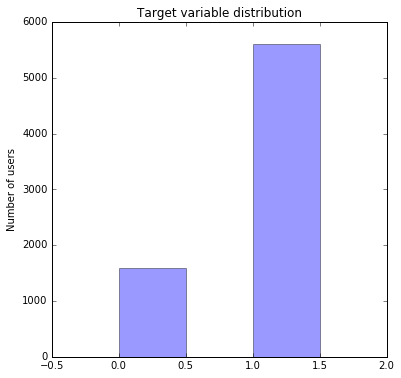

In [4]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)

pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [5]:
CONSUMER_KEY = "tZhRkI5cQarNQUfMPyqDf8E3C"
CONSUMER_SECRET = "pAL7AY7Z3IshhsQd8H71AbW99ni3CkRKi9ayHhNF9ZUTFRZx4L"

ACCESS_TOKEN_KEY = "779945804337471488-qQebZWKYEC3VgyQMpSDIDm1FclVTIYr"
ACCESS_TOKEN_SECRET = "qWPX0jVHBEgeWCmK8bCO5qbmBIXYCyJx6xmwIkGf0zjlk"


api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [6]:
GEO_USER_NAME = "elana"
import requests
import json

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
   
    result = ()
    

    url = "http://api.geonames.org/searchJSON?q=" + location + "&maxRows=5&username=" + GEO_USER_NAME + "&type=json"
 
    try:
        r = requests.get(url)
        data = json.loads(r.text)
      #  data = r.json()
        #print data
        if data['totalResultsCount'] == 0:
            #print "None"
            return (None,None,None)
        i = data['geonames'][0]
        name = i['countryName'] if i['countryName'] != 'unknown' else None
        lat = float(i['lat']) if i['lat'] != 'unknown' else None
        lng = float(i['lng']) if i['lng'] != 'unknown' else None
        result = (lat,lng,name)

    except KeyError:
        #print "error"
        return (None,None,None)
    return result
        
    #return result, all_locations
# your code here
#print all_locations
print get_coordinates_by_location("Los Angeles")

(34.05223, -118.24368, u'United States')


Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [ ]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
       # if user.location in all_locations:
       #         record["lat"], record["lon"], record["country"] = all_locations[user.location]
        #else:
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
        
    
    return record


def get_user_records(df):
    result = []
    
    j = 0
    for u_id in df_users['uid']:
        if u_id in processed_users:
            j+=1
    for i in range(j,len(df),100):

        block = df['uid'].values[i:i+100].tolist()
       
        users = api.UsersLookup(user_id = block)
        for u in users:
            rec = twitter_user_to_dataframe_record(u)
            result.append(rec)
            json.dump(rec,f)
            f.write('\n')
        print "Downloaded " + str(len(result)) + " users" 
    print i, j
        
   
    return result

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"
print len(df_users)

Downloaded 92 users
Downloaded 180 users
Downloaded 266 users
Downloaded 359 users


Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

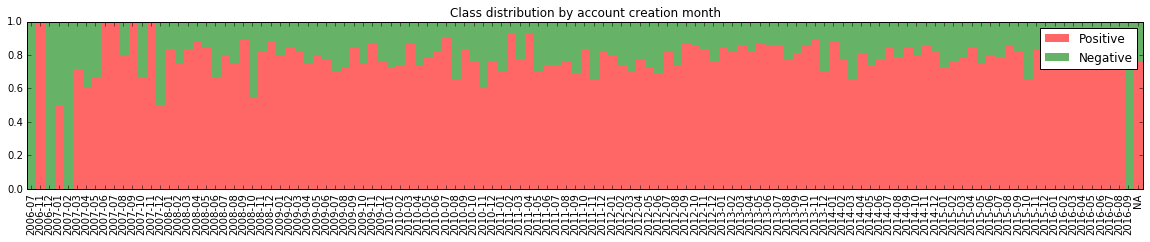

In [8]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    #for i in range(len(grouped)):
        
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here 
    for i in range(len(grouped)):
        month = list(grouped)[i][0]
        
        #print month
        dts.append(month)
        for count in grouped.get_group(month)['cls']:
    
            if count == 0:
                count_neg[i] += 1
                #print month, count, i
            elif count == 1:
                count_pos[i] += 1
                #print month, count, i
            #else:
                #print "nooo ", month, count
   
    return count_pos, count_neg, dts
    


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

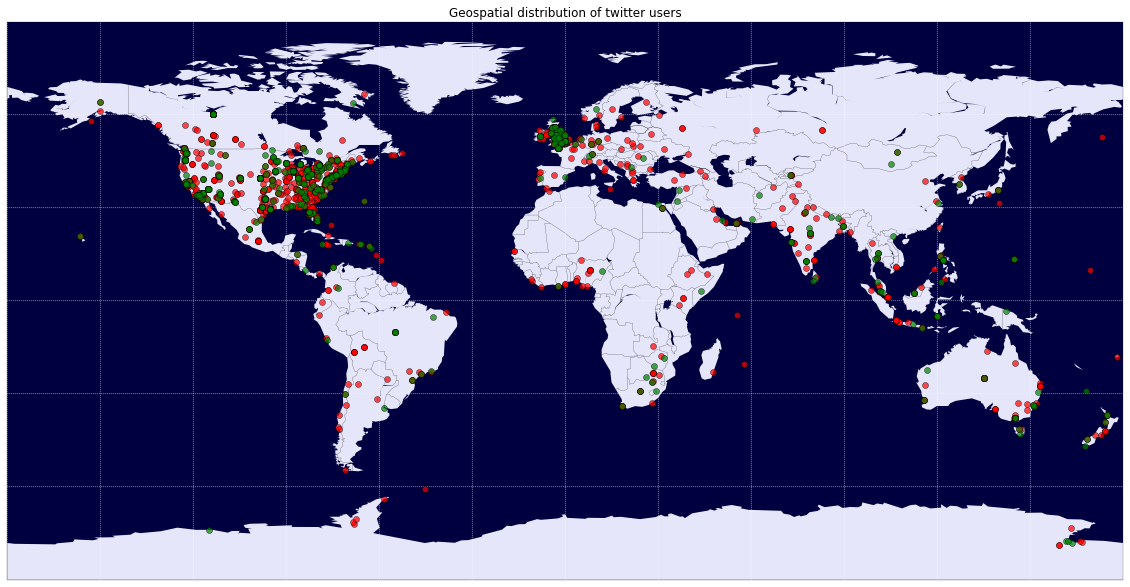

In [24]:
from collections import OrderedDict
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    lon_neg, lon_pos, lat_neg, lat_pos = [], [], [], []
    for i in range(len(df_full)):
        lon = df_full['lon'][i]
        lat = df_full['lat'][i]
        if lon == None or lat == None :
            continue
        x,y = m(lon, lat) 
        if df_full['cls'][i] == 0:
            lon_neg.append(lon)
            lat_neg.append(lat)
        if df_full['cls'][i] == 1:
            lon_pos.append(lon)
            lat_pos.append(lat)

  
    x,y = m(lon_pos, lat_pos)
    m.plot(x, y, 'o', color = 'r', alpha = 0.7)
    
    

    x,y = m(lon_neg, lat_neg)
    m.plot(x, y, 'o', color = 'g', alpha = 0.7)
 
     
    return

        
plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Метки зеленого цвета отображаются полупрозрачными, что позволяет сквозь них видеть метки красного цвета. Коэффициент alpha подобран эмпирически 
* ...

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

In [ ]:
print "min = ", min(df_full['followers_count'])
print "max = ",max(df_full['followers_count'])
a = list()
for i in range(len(df_full)):
    if df_full['followers_count'][i] >= 0:
        a.append(df_full['followers_count'][i])
print "median = ",np.median(a)
print "mean = ", np.mean(a)

In [ ]:
1. mean и median имеют разные значения, т.к. в выборке присутствует большое количество пользователей с 
небольшим количеством фолловеров (< 5000) и несколько пользователей с очень большим (> 100000), поэтому  mean 
значительно больше median
2. в среднем у пользователей положительного класса (класса 1 ) больше показатель followers_count, 
значит они популярнее

In [ ]:
import random
pos , neg = [], []
N = 800
pos_sum = 0
neg_sum = 0
for n in range(len(df_full)):
    a = random.randrange(0,len(df_full),1)
   # print df_full['followers_count'][a]
    if df_full['cls'][a] == 0:
        if len(neg) < N and df_full['followers_count'][a] >=0:
            neg_sum +=df_full['followers_count'][a]
            neg.append(df_full['followers_count'][a])
    if df_full['cls'][a] == 1:
        if len(pos)< N:
            pos_sum += df_full['followers_count'][a]
           
            pos.append(df_full['followers_count'][a])
    else:
        continue
    if len(pos) == N and len(neg)==N:
        break

counts1, bins1 = np.histogram(pos, bins=[0,5000,10000,15000,20000,25000,90000, 600000], range = (0, 1500000))
counts2, bins2 = np.histogram(neg, bins =[0,5000,10000,15000,20000,25000, 90000, 600000], range = (0, 1500000) )
# Plot the distribution
width = 0.6;

print counts1, counts2
print max(pos)
print max(neg)
ind = np.arange(7)
pl.figure(figsize=(5,9))
pl.bar(ind, counts1, width, alpha=1, color = 'green', label = 'number of followers for negative users')
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=2,
       ncol=2, mode="expand", borderaxespad=0.)
pl.bar(ind + width/5, counts2, width , alpha = 1, color  = 'red', label = 'number of followers for positive users')
#pl.xticks(bins[:-1] + 0.3, ["0", "5000", "10000", "15000"])
#pl.xlim(bins[0] - 0.5, bins[-1])
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

pl.xlim(-width,len(ind)+width)
pl.ylim(0,max(max(counts1), max(counts2))+ 10)
pl.ylabel('Frequency')
pl.title('Followers number')
xTickMarks = [i*5000 for i in range(0,5)]
#pl.xticks(ind + width)
pl.xticks(ind + width/2, ["0", "5000", "10000", "15000", "20000", "25000", "90000"," 600000"])
#xtickNames = pl.xticklabels(xTickMarks)
#plt.setp(xtickNames, rotation=45, fontsize=10)

pl.show()



Смотрим на полученный data frame и сохраняем его в .csv файл.

In [ ]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()